In [1]:
from keras.applications import VGG16

image_size = 224
train_dir = "dataset_train_deep"
validation_dir = "dataset_valid_deep"
classes = 10

#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 4 layers
#for layer in vgg_conv.layers[:-4]:;
    #layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

Using TensorFlow backend.


<keras.engine.input_layer.InputLayer object at 0x000000737A5021D0> False
<keras.layers.convolutional.Conv2D object at 0x00000073022C8828> True
<keras.layers.convolutional.Conv2D object at 0x00000073022CE630> True
<keras.layers.pooling.MaxPooling2D object at 0x00000073024EC828> True
<keras.layers.convolutional.Conv2D object at 0x00000073024EC6A0> True
<keras.layers.convolutional.Conv2D object at 0x000000730252F128> True
<keras.layers.pooling.MaxPooling2D object at 0x000000730254C5C0> True
<keras.layers.convolutional.Conv2D object at 0x000000730254C438> True
<keras.layers.convolutional.Conv2D object at 0x000000730256DD68> True
<keras.layers.convolutional.Conv2D object at 0x0000007302586FD0> True
<keras.layers.pooling.MaxPooling2D object at 0x00000073025C15C0> True
<keras.layers.convolutional.Conv2D object at 0x00000073025C1438> True
<keras.layers.convolutional.Conv2D object at 0x00000073025E4D68> True
<keras.layers.convolutional.Conv2D object at 0x00000073025FDFD0> True
<keras.layers.poo

In [2]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 30
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3789 images belonging to 10 classes.
Found 1363 images belonging to 10 classes.


In [4]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
#model.save('small_last4.h5')

Epoch 1/30
190/189 [==============================] - 80s 419ms/step - loss: 2.0574 - acc: 0.2466 - val_loss: 1.9936 - val_acc: 0.2384
Epoch 2/30
190/189 [==============================] - 73s 383ms/step - loss: 1.8930 - acc: 0.2868 - val_loss: 1.8999 - val_acc: 0.2825
Epoch 3/30
190/189 [==============================] - 73s 382ms/step - loss: 1.8334 - acc: 0.3113 - val_loss: 1.8662 - val_acc: 0.2861
Epoch 4/30
190/189 [==============================] - 73s 383ms/step - loss: 1.8029 - acc: 0.3161 - val_loss: 1.8413 - val_acc: 0.3059
Epoch 5/30
190/189 [==============================] - 73s 383ms/step - loss: 1.7795 - acc: 0.3178 - val_loss: 1.8147 - val_acc: 0.3140
Epoch 6/30
190/189 [==============================] - 73s 383ms/step - loss: 1.7559 - acc: 0.3288 - val_loss: 1.9210 - val_acc: 0.2450
Epoch 7/30
190/189 [==============================] - 73s 383ms/step - loss: 1.7495 - acc: 0.3428 - val_loss: 1.8144 - val_acc: 0.2876
Epoch 8/30
190/189 [==============================] - 7

In [5]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [6]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:13]:
    layer.trainable = False
for layer in model.layers[13:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/50
190/189 [==============================] - 78s 411ms/step - loss: 1.5971 - acc: 0.3840 - val_loss: 1.7597 - val_acc: 0.3412
Epoch 2/50
190/189 [==============================] - 74s 387ms/step - loss: 1.4981 - acc: 0.4079 - val_loss: 1.6779 - val_acc: 0.3720
Epoch 3/50
190/189 [==============================] - 74s 388ms/step - loss: 1.4442 - acc: 0.4377 - val_loss: 1.7079 - val_acc: 0.3463
Epoch 4/50
190/189 [==============================] - 74s 389ms/step - loss: 1.4092 - acc: 0.4496 - val_loss: 1.6282 - val_acc: 0.3500
Epoch 5/50
190/189 [==============================] - 74s 387ms/step - loss: 1.3489 - acc: 0.4667 - val_loss: 1.5761 - val_acc: 0.3830
Epoch 6/50
190/189 [==============================] - 74s 388ms/step - loss: 1.3251 - acc: 0.4783 - val_loss: 1.5544 - val_acc: 0.3918
Epoch 7/50
190/189 [==============================] - 74s 392ms/step - loss: 1.3061 - acc: 0.4758 - val_loss: 1.6611 - val_acc: 0.3874
Epoch 8/50
190/189 [==============================] - 7

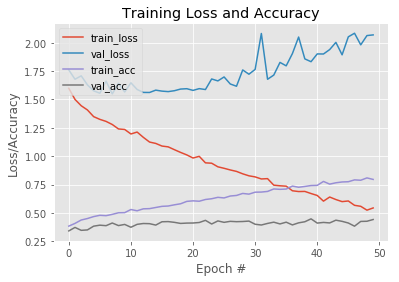

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("FinetuneVGG16")

In [14]:
import csv
import os
import cv2
from keras.preprocessing.image import img_to_array

def readFaces(dir,mydict):
    faces = []
    ages = []
    directory = os.fsencode(dir)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png") or filename.endswith(".jpg"): 
            path = ".\\" + dir + "\\" + filename
            img = cv2.imread(path)
            img = cv2.resize(img, (224, 224))
            img = img.astype("float16") / 255.0
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            faces.append(img)
            ages.append(mydict.get(filename))
    return np.asarray(faces),ages

with open('ground_truth/test_gt.csv', 'r') as f:
    reader = csv.reader(f)
    mydict = dict((rows[0],rows[1]) for rows in reader)

x_test,y_test = readFaces("test_deep",mydict)

def arrangeLabels(Y,bins,labels):
    returnLabels = []
    for label in Y:
        for index in range(len(bins)):
            if float(label) > bins[index]:
                continue;
            else:
                returnLabels.append(labels[index-1])
                break;
                
    return returnLabels

bins = [0.0, 6.0, 13.0, 20.0, 27.0, 34.0, 41.0, 48.0, 55.0, 62.0,np.inf]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

y_test = np.array(arrangeLabels(y_test,bins,labels))

hit = 0
total = len(x_test)
for index in range(total):
    # classify the input image
    print("[INFO] classifying image...")
    proba = model.predict(x_test[index])[0]
    idx = np.argmax(proba)
    print("Predicted "+str(idx)," Actual "+str(y_test[index]))
    hit += idx==y_test[index]

print(hit/total)

[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 7  Actual 8
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 4  Actual 7
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 3  Actual 8
[INFO] classifying image...
Predicted 7  Actual 7
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 8  Actual 9
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 1  Actual 4
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 4  Actual 5


Predicted 4  Actual 4
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 5  Actual 6
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 5  Actual 2
[INFO] classifying image...
Predicted 5  Actual 7
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 6  Actual 5
[INFO] classifying image...
Predicted 5  Actual 9
[INFO] classifying image...
Predicted 8  Actual 9
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 5  Actual 6
[INFO] classifying image...
Predicted 5  Actual 5
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 2  Actual 4
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...


Predicted 6  Actual 6
[INFO] classifying image...
Predicted 4  Actual 2
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 5  Actual 5
[INFO] classifying image...
Predicted 2  Actual 2
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 1
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 5  Actual 5
[INFO] classifying image...
Predicted 7  Actual 7
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 6  Actual 8
[INFO] classifying image...


Predicted 8  Actual 7
[INFO] classifying image...
Predicted 7  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 4  Actual 2
[INFO] classifying image...
Predicted 7  Actual 8
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 6  Actual 8
[INFO] classifying image...
Predicted 7  Actual 3
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 7  Actual 8
[INFO] classifying image...
Predicted 0  Actual 2
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 5  Actual 8
[INFO] classifying image...
Predicted 7  Actual 8
[INFO] classifying image...
Predicted 1  Actual 8
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 1  Actual 2
[INFO] classifying image...
Predicted 0  Actual 4
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...


Predicted 5  Actual 5
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 7  Actual 7
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 7  Actual 9
[INFO] classifying image...
Predicted 3  Actual 5
[INFO] classifying image...
Predicted 0  Actual 2
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 8  Actual 9
[INFO] classifying image...
Predicted 2  Actual 3
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 7
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 6  Actual 6
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 5  Actual 6
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...


Predicted 3  Actual 1
[INFO] classifying image...
Predicted 2  Actual 3
[INFO] classifying image...
Predicted 3  Actual 9
[INFO] classifying image...
Predicted 2  Actual 2
[INFO] classifying image...
Predicted 6  Actual 6
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 2  Actual 2
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 4  Actual 8
[INFO] classifying image...
Predicted 4  Actual 1
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 5  Actual 8
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...


Predicted 6  Actual 4
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 9  Actual 9
[INFO] classifying image...
Predicted 7  Actual 5
[INFO] classifying image...
Predicted 4  Actual 7
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 7  Actual 9
[INFO] classifying image...
Predicted 3  Actual 5
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 2  Actual 0
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 7  Actual 5
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 5  Actual 9
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 2  Actual 2
[INFO] classifying image...
Predicted 4  Actual 7
[INFO] classifying image...


Predicted 3  Actual 3
[INFO] classifying image...
Predicted 5  Actual 6
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 2  Actual 1
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 3  Actual 1
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 4  Actual 5
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 5  Actual 7
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 3  Actual 5
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 5  Actual 6
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...


Predicted 6  Actual 5
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 2  Actual 6
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 6  Actual 6
[INFO] classifying image...
Predicted 5  Actual 3
[INFO] classifying image...
Predicted 4  Actual 6
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 5  Actual 5
[INFO] classifying image...
Predicted 8  Actual 9
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 6  Actual 4
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 7  Actual 9
[INFO] classifying image...
Predicted 3  Actual 5
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 3  Actual 1
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...


Predicted 4  Actual 3
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 5  Actual 4
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 5  Actual 5
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 0  Actual 4
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 6  Actual 9
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 7  Actual 9
[INFO] classifying image...
Predicted 1  Actual 0
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 2  Actual 0
[INFO] classifying image...


Predicted 5  Actual 5
[INFO] classifying image...
Predicted 2  Actual 0
[INFO] classifying image...
Predicted 6  Actual 4
[INFO] classifying image...
Predicted 5  Actual 3
[INFO] classifying image...
Predicted 6  Actual 3
[INFO] classifying image...
Predicted 1  Actual 1
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...
Predicted 2  Actual 1
[INFO] classifying image...
Predicted 0  Actual 1
[INFO] classifying image...
Predicted 3  Actual 3
[INFO] classifying image...
Predicted 0  Actual 0
[INFO] classifying image...
Predicted 3  Actual 2
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 0  Actual 1
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 4  Actual 3
[INFO] classifying image...
Predicted 4  Actual 0
[INFO] classifying image...
Predicted 4  Actual 4
[INFO] classifying image...
Predicted 3  Actual 4
[INFO] classifying image...


In [ ]:
model.save("FinetuneVGG16.h")